<a href="https://colab.research.google.com/github/mohigeo33/ls_lst_c2/blob/main/LST_C2_Timeseries_withanimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'History'
# LST and Time series added
# Phnom Penh AOI, and Clipping Added
# To do: Clipping gives some NA values, to resolve that, need to do WRS ROW PATH filtering

'History'

In [ ]:
# installing libraries
!pip install geemap --upgrade
!pip install geopandas
!pip install pyshp
!pip install pycrs
!pip install Pillow
!pip install imageio
!pip install retry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11122 sha256=fbdbd7c2d416ab93a0afca26b8f44a845da35a71c564f85c2bc8c4269f75302c
  Stored in directory: /root/.cache/pip/wheels/04/24/fe/140a94a7f1036003ede94579e6b4227

In [ ]:
# loading necessary libraries
import os
import sys
import ee
import geemap
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import math

In [ ]:
# trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=4_9dCvjNzqEkDoVm3H8zY67f8E2hs0GRiHV2XvZfc0E&tc=iI4ft7s40wZW7jEY2lzN9JohCYs6cTfnbi4N6tQuCtc&cc=uUBQ5jEnaDIQkTenRk88R595INUnBfmUUra_BVYdZBM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BUhCJy2dnRFbZjmBfxpYxZvQEJsr7DtcrTwDORbbrTlzhXB_V6i09w

Successfully saved authorization token.


In [ ]:
# initialize the GEE.
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [ ]:
# NDVI band add
def ndvi_band_add(landsat):
  def wrap(image):

      # choose bands
      nir = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B5',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B5', 'SR_B4')))
      red = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B4',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B4', 'SR_B3')))

      # compute NDVI
      ndvi = image.expression('(nir-red)/(nir+red)', {
          'nir': image.select(nir).multiply(0.0000275).add(-0.2),
          'red': image.select(red).multiply(0.0000275).add(-0.2)
      }).rename('NDVI')

      return image.addBands(ndvi)
  return wrap


# EVI band add
def evi_band_add(landsat):
  def wrap(image):
    coef1 = ee.Number(2.5)
    coef_red = ee.Number(6)
    coef_blue = ee.Number(7.5)
    const = ee.Number(1)

    # choose bands
    nir = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B5',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B5', 'SR_B4')))
    red = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B4',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B4', 'SR_B3')))
    blue = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B2',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B2', 'SR_B1')))

    # compute EVI
    evi = image.expression('coef1*((nir-red)/(nir + (coef_red*red)-(coef_blue*blue) + const))', {
          'nir': image.select(nir).multiply(0.0000275).add(-0.2),
          'red': image.select(red).multiply(0.0000275).add(-0.2),
          'blue': image.select(blue).multiply(0.0000275).add(-0.2),
          'coef1':coef1,
          'coef_red':coef_red,
          'coef_blue':coef_blue,
          'const':const,
      }).rename('EVI')
    return image.addBands(evi)
  return wrap


# SAVI band add
def savi_band_add(landsat):
  def wrap(image):

      # choose bands
      nir = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B5',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B5', 'SR_B4')))
      red = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B4',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B4', 'SR_B3')))

      # compute savi
      l = ee.Number(0.5)
      savi = image.expression('((nir - red) / (nir + red + l)) * (1+l)',{
          'nir': image.select(nir).multiply(0.0000275).add(-0.2),
          'red': image.select(red).multiply(0.0000275).add(-0.2),
          'l': l}).rename('SAVI')

      return image.addBands(savi)
  return wrap


# NDBI band add
def ndbi_band_add(landsat):
  def wrap(image):

      # choose bands
      nir = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B5',
                                        ee.Algorithms.If(landsat == 'L9', 'SR_B5', 'SR_B4')))
      swir1 = ee.String(ee.Algorithms.If(landsat == 'L9', 'SR_B6',
                                          ee.Algorithms.If(landsat == 'L8', 'SR_B6', 'SR_B5' )))


      # compute ndbi
      ndbi = image.expression('(swir1-nir)/(swir1+nir)', {
          'nir': image.select(nir).multiply(0.0000275).add(-0.2),
          'swir1': image.select(swir1).multiply(0.0000275).add(-0.2)
      }).rename('NDBI')

      return image.addBands(ndbi)
  return wrap


# Modified NDWI band add
def ndwi_band_add(landsat):
  def wrap(image):

      # choose bands
      #green l4=2, l5=2, l7=2, l8=3, l9=3
      green = ee.String(ee.Algorithms.If(landsat == 'L9', 'SR_B3',
                                        ee.Algorithms.If(landsat == 'L8', 'SR_B3', 'SR_B2')))
      swir1 = ee.String(ee.Algorithms.If(landsat == 'L9', 'SR_B6',
                                          ee.Algorithms.If(landsat == 'L8', 'SR_B6', 'SR_B5' )))


      # compute mndwi
      ndwi = image.expression('(green-swir1)/(green+swir1)', {
          'green': image.select(green).multiply(0.0000275).add(-0.2),
          'swir1': image.select(swir1).multiply(0.0000275).add(-0.2)
      }).rename('NDWI')

      return image.addBands(ndwi)
  return wrap


# IBI band add
def ibi_band_add(landsat):
  def wrap(image):
    const = ee.Number(2)

    # choose bands
    nir = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B5',
                                      ee.Algorithms.If(landsat == 'L9', 'SR_B5', 'SR_B4')))
    red = ee.String(ee.Algorithms.If(landsat == 'L8', 'SR_B4',
                                      ee.Algorithms.If(landsat == 'L9', 'SR_B4', 'SR_B3')))
    green = ee.String(ee.Algorithms.If(landsat == 'L9', 'SR_B3',
                                         ee.Algorithms.If(landsat == 'L8', 'SR_B3', 'SR_B2')))
    swir1 = ee.String(ee.Algorithms.If(landsat == 'L9', 'SR_B6',
                                           ee.Algorithms.If(landsat == 'L8', 'SR_B6', 'SR_B5' )))

    # compute IBI
    ibi = image.expression(
        '(((const * swir1) / (swir1 + nir))-((nir / (nir + red)) + (green / (green + swir1))))   / (((const * swir1) / (swir1 + nir))+((nir / (nir + red)) + (green / (green + swir1))))', {
        'nir': image.select(nir).multiply(0.0000275).add(-0.2),
        'red': image.select(red).multiply(0.0000275).add(-0.2),
        'green': image.select(green).multiply(0.0000275).add(-0.2),
        'swir1': image.select(swir1).multiply(0.0000275).add(-0.2),
        'const': const
    }).rename('IBI')

    return image.addBands(ibi)
  return wrap



# FVC band add
def fvc_band_add(landsat):
  def wrap(image):

      ndvi = image.select('NDVI')

      # Compute FVC
      fvc = image.expression('((ndvi-ndvi_bg)/(ndvi_vg - ndvi_bg))**2',
                              {'ndvi': ndvi, 'ndvi_bg': 0.2, 'ndvi_vg': 0.86})
      fvc = fvc.where(fvc.lt(0.0), 0.0)
      fvc = fvc.where(fvc.gt(1.0), 1.0)

      return image.addBands(fvc.rename('FVC'))

  return wrap


# NCEP band add for atmospheric correction
def ncep_band_add(image):
  # first select the day of interest
  date = ee.Date(image.get('system:time_start'))
  year = ee.Number.parse(date.format('yyyy'))
  month = ee.Number.parse(date.format('MM'))
  day = ee.Number.parse(date.format('dd'))
  date1 = ee.Date.fromYMD(year, month, day)
  date2 = date1.advance(1, 'days')

  # function compute the time difference from Landsat image
  def datedist(img):
      return img.set('DateDist', ee.Number(img.get('system:time_start')).subtract(date.millis()).abs())

  # load atmospheric data collection
  TPWcollection = ee.ImageCollection('NCEP_RE/surface_wv').filter(
      ee.Filter.date(date1.format('yyyy-MM-dd'), date2.format('yyyy-MM-dd'))).map(datedist)

  # select the two closest model times
  closest = TPWcollection.sort('DateDist').toList(2)

  tpw1 = ee.Image(ee.Algorithms.If(closest.size().eq(0), ee.Image.constant(-999.0),
                                    ee.Image(closest.get(0)).select('pr_wtr')))
  tpw2 = ee.Image(ee.Algorithms.If(closest.size().eq(0), ee.Image.constant(-999.0),
                                    ee.Algorithms.If(closest.size().eq(1), tpw1,
                                                      ee.Image(closest.get(1)).select('pr_wtr'))))

  time1 = ee.Number(ee.Algorithms.If(closest.size().eq(0), 1.0,
                                      ee.Number(tpw1.get('DateDist')).divide(ee.Number(21600000))))
  time2 = ee.Number(ee.Algorithms.If(closest.size().lt(2), 0.0,
                                      ee.Number(tpw2.get('DateDist')).divide(ee.Number(21600000))))

  tpw = tpw1.expression('tpw1*time2+tpw2*time1',
                        {'tpw1': tpw1, 'time1': time1, 'tpw2': tpw2, 'time2': time2}).clip(image.geometry())

  pos = tpw.expression(
      "value = (TPW>0 && TPW<=6) ? 0" +
      ": (TPW>6 && TPW<=12) ? 1" +
      ": (TPW>12 && TPW<=18) ? 2" +
      ": (TPW>18 && TPW<=24) ? 3" +
      ": (TPW>24 && TPW<=30) ? 4" +
      ": (TPW>30 && TPW<=36) ? 5" +
      ": (TPW>36 && TPW<=42) ? 6" +
      ": (TPW>42 && TPW<=48) ? 7" +
      ": (TPW>48 && TPW<=54) ? 8" +
      ": (TPW>54) ? 9" +
      ": 0", {'TPW': tpw}).clip(image.geometry())

  # add tpw to image as a band
  withTPW = image.addBands(tpw.rename('TPW'), ['TPW']).addBands(pos.rename('TPWpos'), ['TPWpos'])

  return withTPW




# Cloud mask for TOA data
def cloudmask_toa(image):
  qa = image.select('QA_PIXEL')
  mask = qa.bitwiseAnd(1 << 3)
  return image.updateMask(mask.Not())

# Cloud mask for SR data
def cloudmask_sr(image):
  qa = image.select('QA_PIXEL')
  mask = (qa.bitwiseAnd(1 << 3)
          .Or(qa.bitwiseAnd(1 << 4)))
  return image.updateMask(mask.Not())



In [ ]:
class ASTERGED:
    # get ASTER emissivity
    aster = ee.Image("NASA/ASTER_GED/AG100_003")

    # get ASTER FVC from NDVI
    aster_ndvi = aster.select('ndvi').multiply(0.01)

    aster_fvc = aster_ndvi.expression('((ndvi-ndvi_bg)/(ndvi_vg - ndvi_bg))**2',
                                       {'ndvi': aster_ndvi, 'ndvi_bg': 0.2, 'ndvi_vg': 0.86})
    aster_fvc = aster_fvc.where(aster_fvc.lt(0.0), 0.0)
    aster_fvc = aster_fvc.where(aster_fvc.gt(1.0), 1.0)

    @staticmethod
    def emiss_bare_band10(image):
        return image.expression('(EM - 0.99*fvc)/(1.0-fvc)',
                                {'EM': ASTERGED.aster.select('emissivity_band10').multiply(0.001),
                                 'fvc': ASTERGED.aster_fvc}).clip(image.geometry())

    @staticmethod
    def emiss_bare_band11(image):
        return image.expression('(EM - 0.99*fvc)/(1.0-fvc)',
                                {'EM': ASTERGED.aster.select('emissivity_band11').multiply(0.001),
                                 'fvc': ASTERGED.aster_fvc}).clip(image.geometry())

    @staticmethod
    def emiss_bare_band12(image):
        return image.expression('(EM - 0.99*fvc)/(1.0-fvc)',
                                {'EM': ASTERGED.aster.select('emissivity_band12').multiply(0.001),
                                 'fvc': ASTERGED.aster_fvc}).clip(image.geometry())

    @staticmethod
    def emiss_bare_band13(image):
        return image.expression('(EM - 0.99*fvc)/(1.0-fvc)',
                                {'EM': ASTERGED.aster.select('emissivity_band13').multiply(0.001),
                                 'fvc': ASTERGED.aster_fvc}).clip(image.geometry())

    @staticmethod
    def emiss_bare_band14(image):
        return image.expression('(EM - 0.99*fvc)/(1.0-fvc)',
                                {'EM': ASTERGED.aster.select('emissivity_band14').multiply(0.001),
                                 'fvc': ASTERGED.aster_fvc}).clip(image.geometry())




def emmisvity_add_band(landsat, use_ndvi):
    def wrap(image):
        c13 = ee.Number(ee.Algorithms.If(landsat == 'L4', 0.3222,
                                         ee.Algorithms.If(landsat == 'L5', -0.0723,
                                                          ee.Algorithms.If(landsat == 'L7', 0.2147,
                                                                           0.6820))))
        c14 = ee.Number(ee.Algorithms.If(landsat == 'L4', 0.6498,
                                         ee.Algorithms.If(landsat == 'L5', 1.0521,
                                                          ee.Algorithms.If(landsat == 'L7', 0.7789,
                                                                           0.2578))))
        c = ee.Number(ee.Algorithms.If(landsat == 'L4', 0.0272,
                                       ee.Algorithms.If(landsat == 'L5', 0.0195,
                                                        ee.Algorithms.If(landsat == 'L7', 0.0059,
                                                                         0.0584))))

        # get ASTER emissivity
        # convolve to Landsat band
        emiss_bare = image.expression('c13*EM13 + c14*EM14 + c', {
            'EM13': ASTERGED.emiss_bare_band13(image),
            'EM14': ASTERGED.emiss_bare_band14(image),
            'c13': ee.Image(c13),
            'c14': ee.Image(c14),
            'c': ee.Image(c)
        })

        # compute the dynamic emissivity for Landsat
        EMd = image.expression('fvc*0.99+(1-fvc)*em_bare',
                               {'fvc': image.select('FVC'), 'em_bare': emiss_bare})

        # compute emissivity directly from ASTER without vegetation correction
        aster = ee.Image("NASA/ASTER_GED/AG100_003").clip(image.geometry())
        EM0 = image.expression('c13*EM13 + c14*EM14 + c', {
            'EM13': aster.select('emissivity_band13').multiply(0.001),
            'EM14': aster.select('emissivity_band14').multiply(0.001),
            'c13': ee.Image(c13),
            'c14': ee.Image(c14),
            'c': ee.Image(c)
        })

        # select which emissivity to output based on user selection
        EM = ee.Image(ee.Algorithms.If(use_ndvi, EMd, EM0))

        # prescribe emissivity of water bodies
        qa = image.select('QA_PIXEL')
        EM = EM.where(qa.bitwiseAnd(1 << 7), 0.99)

        # prescribe emissivity of snow/ice bodies
        EM = EM.where(qa.bitwiseAnd(1 << 5), 0.989)

        return image.addBands(EM.rename('EM'))

    return wrap


In [ ]:
# Calculating LST

def add_lst_band(landsat):
  SMWcoef = {
    'coeff_SMW_L4':ee.FeatureCollection([
      ee.Feature(None, {'TPWpos': 0, 'A': 0.9755, 'B': -205.2767, 'C': 212.0051}),
      ee.Feature(None, {'TPWpos': 1, 'A': 1.0155, 'B': -233.8902, 'C': 230.4049}),
      ee.Feature(None, {'TPWpos': 2, 'A': 1.0672, 'B': -257.1884, 'C': 239.3072}),
      ee.Feature(None, {'TPWpos': 3, 'A': 1.1499, 'B': -286.2166, 'C': 244.8497}),
      ee.Feature(None, {'TPWpos': 4, 'A': 1.2277, 'B': -316.7643, 'C': 253.0033}),
      ee.Feature(None, {'TPWpos': 5, 'A': 1.3649, 'B': -361.8276, 'C': 258.5471}),
      ee.Feature(None, {'TPWpos': 6, 'A': 1.5085, 'B': -410.1157, 'C': 265.1131}),
      ee.Feature(None, {'TPWpos': 7, 'A': 1.7045, 'B': -472.4909, 'C': 270.7000}),
      ee.Feature(None, {'TPWpos': 8, 'A': 1.5886, 'B': -442.9489, 'C': 277.1511}),
      ee.Feature(None, {'TPWpos': 9, 'A': 2.0215, 'B': -571.8563, 'C': 279.9854})
    ]),

    'coeff_SMW_L5': ee.FeatureCollection([
      ee.Feature(None, {'TPWpos': 0, 'A': 0.9765, 'B': -204.6584, 'C': 211.1321}),
      ee.Feature(None, {'TPWpos': 1, 'A': 1.0229, 'B': -235.5384, 'C': 230.0619}),
      ee.Feature(None, {'TPWpos': 2, 'A': 1.0817, 'B': -261.3886, 'C': 239.5256}),
      ee.Feature(None, {'TPWpos': 3, 'A': 1.1738, 'B': -293.6128, 'C': 245.6042}),
      ee.Feature(None, {'TPWpos': 4, 'A': 1.2605, 'B': -327.1417, 'C': 254.2301}),
      ee.Feature(None, {'TPWpos': 5, 'A': 1.4166, 'B': -377.7741, 'C': 259.9711}),
      ee.Feature(None, {'TPWpos': 6, 'A': 1.5727, 'B': -430.0388, 'C': 266.9520}),
      ee.Feature(None, {'TPWpos': 7, 'A': 1.7879, 'B': -498.1947, 'C': 272.8413}),
      ee.Feature(None, {'TPWpos': 8, 'A': 1.6347, 'B': -457.8183, 'C': 279.6160}),
      ee.Feature(None, {'TPWpos': 9, 'A': 2.1168, 'B': -600.7079, 'C': 282.4583})
    ]),

    'coeff_SMW_L7': ee.FeatureCollection([
      ee.Feature(None, {'TPWpos': 0, 'A': 0.9764, 'B': -205.3511, 'C': 211.8507}),
      ee.Feature(None, {'TPWpos': 1, 'A': 1.0201, 'B': -235.2416, 'C': 230.5468}),
      ee.Feature(None, {'TPWpos': 2, 'A': 1.0750, 'B': -259.6560, 'C': 239.6619}),
      ee.Feature(None, {'TPWpos': 3, 'A': 1.1612, 'B': -289.8190, 'C': 245.3286}),
      ee.Feature(None, {'TPWpos': 4, 'A': 1.2425, 'B': -321.4658, 'C': 253.6144}),
      ee.Feature(None, {'TPWpos': 5, 'A': 1.3864, 'B': -368.4078, 'C': 259.1390}),
      ee.Feature(None, {'TPWpos': 6, 'A': 1.5336, 'B': -417.7796, 'C': 265.7486}),
      ee.Feature(None, {'TPWpos': 7, 'A': 1.7345, 'B': -481.5714, 'C': 271.3659}),
      ee.Feature(None, {'TPWpos': 8, 'A': 1.6066, 'B': -448.5071, 'C': 277.9058}),
      ee.Feature(None, {'TPWpos': 9, 'A': 2.0533, 'B': -581.2619, 'C': 280.6800})
    ]),

    'coeff_SMW_L8': ee.FeatureCollection([
      ee.Feature(None, {'TPWpos': 0, 'A': 0.9751, 'B': -205.8929, 'C': 212.7173}),
      ee.Feature(None, {'TPWpos': 1, 'A': 1.0090, 'B': -232.2750, 'C': 230.5698}),
      ee.Feature(None, {'TPWpos': 2, 'A': 1.0541, 'B': -253.1943, 'C': 238.9548}),
      ee.Feature(None, {'TPWpos': 3, 'A': 1.1282, 'B': -279.4212, 'C': 244.0772}),
      ee.Feature(None, {'TPWpos': 4, 'A': 1.1987, 'B': -307.4497, 'C': 251.8341}),
      ee.Feature(None, {'TPWpos': 5, 'A': 1.3205, 'B': -348.0228, 'C': 257.2740}),
      ee.Feature(None, {'TPWpos': 6, 'A': 1.4540, 'B': -393.1718, 'C': 263.5599}),
      ee.Feature(None, {'TPWpos': 7, 'A': 1.6350, 'B': -451.0790, 'C': 268.9405}),
      ee.Feature(None, {'TPWpos': 8, 'A': 1.5468, 'B': -429.5095, 'C': 275.0895}),
      ee.Feature(None, {'TPWpos': 9, 'A': 1.9403, 'B': -547.2681, 'C': 277.9953})
      ]),
    'coeff_SMW_L9': ee.FeatureCollection([
      ee.Feature(None, {'TPWpos': 0, 'A': 0.9751, 'B': -206.2187, 'C': 213.0526}),
      ee.Feature(None, {'TPWpos': 1, 'A': 1.0093, 'B': -232.7408, 'C': 230.9401}),
      ee.Feature(None, {'TPWpos': 2, 'A': 1.0539, 'B': -253.4430, 'C': 239.2572}),
      ee.Feature(None, {'TPWpos': 3, 'A': 1.1267, 'B': -279.1685, 'C': 244.2379}),
      ee.Feature(None, {'TPWpos': 4, 'A': 1.1961, 'B': -306.7961, 'C': 251.8873}),
      ee.Feature(None, {'TPWpos': 5, 'A': 1.3155, 'B': -346.5312, 'C': 257.2174}),
      ee.Feature(None, {'TPWpos': 6, 'A': 1.4463, 'B': -390.7794, 'C': 263.3479}),
      ee.Feature(None, {'TPWpos': 7, 'A': 1.6229, 'B': -447.2745, 'C': 268.5970}),
      ee.Feature(None, {'TPWpos': 8, 'A': 1.5396, 'B': -427.0904, 'C': 274.6380}),
      ee.Feature(None, {'TPWpos': 9, 'A': 1.9223, 'B': -541.7084, 'C': 277.4964}),
    ])
    }



  def get_lookup_table(fc_list, prop_1, prop_2):
    fc = ee.FeatureCollection(fc_list) # Convert the list to a feature collection
    reducer = ee.Reducer.toList().repeat(2)
    lookup = fc.reduceColumns(reducer, [prop_1, prop_2])
    return ee.List(lookup.get('list'))


  def wrap(image):
    # Select algorithm coefficients
    if landsat == 'L4':
        coeff_SMW = SMWcoef['coeff_SMW_L4']
    elif landsat == 'L5':
        coeff_SMW = SMWcoef['coeff_SMW_L5']
    elif landsat == 'L7':
        coeff_SMW = SMWcoef['coeff_SMW_L7']
    elif landsat == 'L8':
        coeff_SMW = SMWcoef['coeff_SMW_L8']
    else:
        coeff_SMW = SMWcoef['coeff_SMW_L9']

    # Create lookups for the algorithm coefficients
    A_lookup = get_lookup_table(coeff_SMW, 'TPWpos', 'A')
    B_lookup = get_lookup_table(coeff_SMW, 'TPWpos', 'B')
    C_lookup = get_lookup_table(coeff_SMW, 'TPWpos', 'C')

    # Map coefficients to the image using the TPW bin position
    A_img = image.remap(A_lookup.get(0), A_lookup.get(1), 0.0, 'TPWpos').resample('bilinear')
    B_img = image.remap(B_lookup.get(0), B_lookup.get(1), 0.0, 'TPWpos').resample('bilinear')
    C_img = image.remap(C_lookup.get(0), C_lookup.get(1), 0.0, 'TPWpos').resample('bilinear')

    # Select TIR band
    tir = 'B10' if landsat in ['L9', 'L8'] else 'B6_VCID_1' if landsat == 'L7' else 'B6'
    # Compute the LST
    lst = image.expression(
        '(A*Tb1/em1 + B/em1 + C)-273.15',
        {
            'A': A_img,
            'B': B_img,
            'C': C_img,
            'em1': image.select('EM'),
            'Tb1': image.select(tir)
        }
    ).updateMask(image.select('TPW').lt(0).Not())

    return image.addBands(lst.rename('LST'))

  return wrap


In [ ]:
COLLECTION = ee.Dictionary({
  'L4': {
    'TOA': ee.ImageCollection('LANDSAT/LT04/C02/T1_TOA'),
    'SR': ee.ImageCollection('LANDSAT/LT04/C02/T1_L2'),
    'TIR': ['B6',],
    'VISW': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL']
  },
  'L5': {
    'TOA': ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA'),
    'SR': ee.ImageCollection('LANDSAT/LT05/C02/T1_L2'),
    'TIR': ['B6',],
    'VISW': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL']
  },
  'L7': {
    'TOA': ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA'),
    'SR': ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'),
    'TIR': ['B6_VCID_1', 'B6_VCID_2'],
    'VISW': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL']
  },
  'L8': {
    'TOA': ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA'),
    'SR': ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'),
    'TIR': ['B10', 'B11'],
    'VISW': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
  },
  'L9': {
    'TOA': ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA'),
    'SR': ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'),
    'TIR': ['B10', 'B11'],
    'VISW': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
  }
})





# def collection(date_start, date_end, geometry, use_ndvi):
#   landsats = ['L9', 'L8', 'L7', 'L5', 'L4']

#   # Initialize an empty image collection
#   final_collection = ee.ImageCollection([])

#   for landsat in landsats:
#     collection_dict = ee.Dictionary(COLLECTION.get(landsat))
#     landsatTOA = (ee.ImageCollection(collection_dict.get('TOA'))
#                     .filter(ee.Filter.date(date_start, date_end))
#                     .filterBounds(geometry))
#     landsatSR = (ee.ImageCollection(collection_dict.get('SR'))
#                   .filter(ee.Filter.date(date_start, date_end))
#                   .filterBounds(geometry)
#                   .map(cloudmask_sr)
#                   .map(ndvi_band_add(landsat))
#                   .map(fvc_band_add(landsat))
#                   .map(ncep_band_add)
#                   .map(emmisvity_add_band(landsat, use_ndvi))
#                   .map(savi_band_add(landsat))
#                   .map(ndbi_band_add(landsat))
#                   .map(ndwi_band_add(landsat))
#                   .map(ibi_band_add(landsat))
#                   .map(evi_band_add(landsat))
#                   )
#     tir = ee.List(collection_dict.get('TIR'))
#     visw = (ee.List(collection_dict.get('VISW'))
#             .add('NDVI')
#             .add('FVC')
#             .add('TPW')
#             .add('TPWpos')
#             .add('EM')
#             .add('SAVI')
#             .add('NDBI')
#             .add('NDWI')
#             .add('IBI')
#             .add('EVI')
#             )

#     landsatALL = landsatSR.select(visw).combine(landsatTOA.select(tir), True)
#     landsatLST = landsatALL.map(add_lst_band(landsat))

#     # Merge the current landsatLST with the final collection
#     final_collection = final_collection.merge(landsatLST)

#   return final_collection


def collection(date_start, date_end, geometry, use_ndvi):
    landsats = ['L9', 'L8', 'L7', 'L5', 'L4']

    # Initialize an empty image collection
    final_collection = ee.ImageCollection([])

    for landsat in landsats:
        collection_dict = ee.Dictionary(COLLECTION.get(landsat))
        landsatTOA = (ee.ImageCollection(collection_dict.get('TOA'))
                      .filter(ee.Filter.date(date_start, date_end)).map(lambda image: image.clip(geometry))
                      .filterBounds(geometry))
        # LandsatColl_timeSeriesBands_clipped = LandsatColl_timeSeriesBands.map(lambda image: image.clip(geometry))

        landsatSR = (ee.ImageCollection(collection_dict.get('SR'))
                      .filter(ee.Filter.date(date_start, date_end)).map(lambda image: image.clip(geometry))
                      .filterBounds(geometry).map(lambda image: image.clip(geometry))
                      .map(cloudmask_sr)
                      .map(ndvi_band_add(landsat))
                      .map(fvc_band_add(landsat))
                      .map(ncep_band_add)
                      .map(emmisvity_add_band(landsat, use_ndvi))
                      .map(savi_band_add(landsat))
                      .map(ndbi_band_add(landsat))
                      .map(ndwi_band_add(landsat))
                      .map(ibi_band_add(landsat))
                      .map(evi_band_add(landsat))
                      )
        tir = ee.List(collection_dict.get('TIR'))
        visw = (ee.List(collection_dict.get('VISW'))
                .add('NDVI')
                .add('FVC')
                .add('TPW')
                .add('TPWpos')
                .add('EM')
                .add('SAVI')
                .add('NDBI')
                .add('NDWI')
                .add('IBI')
                .add('EVI')
                )

        landsatALL = landsatSR.select(visw).combine(landsatTOA.select(tir), True)
        landsatLST = landsatALL.map(add_lst_band(landsat))

        # Filter images based on whether they completely cover the geometry
        landsatLST = landsatLST.filter(ee.Filter.bounds(geometry))

        # Merge the current landsatLST with the final collection
        final_collection = final_collection.merge(landsatLST)

    return final_collection


In [ ]:
from ee.image import geometry
from ee.featurecollection import FeatureCollection
from ee.image import geometry
# Assuming the LandsatLST module has been defined according to previous conversation
# from LandsatLST_module import collection as LandsatLST

# Select region of interest, date range, and Landsat satellite
geometry_fc = ee.FeatureCollection('projects/ee-kazijahid/assets/PhnomPnhExtent')
geometry = geometry_fc.geometry()
date_start = '2015-05-15'
date_end = '2016-05-31'
use_ndvi = True

# Get Landsat collection with added variables: NDVI, FVC, TPW, EM, LST
LandsatColl = collection(date_start, date_end, geometry, use_ndvi)

timeSeriesBands = ['NDWI', 'NDVI', 'SAVI', 'NDBI', 'IBI', 'EVI', 'LST']
LandsatColl_timeSeriesBands = LandsatColl.select(timeSeriesBands)

# Define the function to clip images
def fctn_clip(img, geometry):
  geometry= ee.FeatureCollection(geometry)
  clip_img = img.clip(geometry)
  return clip_img

def clip_mapper(img, clip_params):
  'The function is supplied to the iterate function'
  clip_params = ee.List(clip_params)
  geometry = clip_params.get(0)
  geometry = ee.FeatureCollection(geometry)


  clipped_image = ee.Image(fctn_clip(img, geometry))
  clip_params = listparams.add(clipped_image)
  return clip_params

# # Create an empty list to collect the image infos.
clip_params = ee.List([])
clip_params = clip_params.add(geometry_fc)
# # Iterate over the collection and normalize each image.
# LandsatColl_timeSeriesBands_c = # Clip all the images in LandsatColl_timeSeriesBands using the geometry


In [ ]:
# LandsatColl_timeSeriesBands_clipped

In [ ]:
import time
# def get_ndbi_info(img,aoi):
def get_ndbi_info(img,aoi):
    'get the max, min and mean ndbi values for the image provided. and returns a dictionary with all the satistics'
    img = img.toFloat()
    # img_date = img.date()
    img_date = img.get('system:time_start')
    img_sytemindex = img.get('system:index')

    min_ndwi_val = ee.Number(img.select('NDWI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('NDWI'))
    max_ndwi_val = ee.Number(img.select('NDWI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('NDWI'))
    mean_ndwi_val = ee.Number(img.select('NDWI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('NDWI'))

    min_ndvi_val = ee.Number(img.select('NDVI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('NDVI'))
    max_ndvi_val = ee.Number(img.select('NDVI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('NDVI'))
    mean_ndvi_val = ee.Number(img.select('NDVI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('NDVI'))

    min_savi_val = ee.Number(img.select('SAVI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('SAVI'))
    max_savi_val = ee.Number(img.select('SAVI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('SAVI'))
    mean_savi_val = ee.Number(img.select('SAVI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('SAVI'))

    min_ndbi_val = ee.Number(img.select('NDBI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('NDBI'))
    max_ndbi_val = ee.Number(img.select('NDBI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('NDBI'))
    mean_ndbi_val = ee.Number(img.select('NDBI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('NDBI'))

    min_ibi_val = ee.Number(img.select('IBI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('IBI'))
    max_ibi_val = ee.Number(img.select('IBI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('IBI'))
    mean_ibi_val = ee.Number(img.select('IBI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('IBI'))

    min_evi_val = ee.Number(img.select('EVI').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('EVI'))
    max_evi_val = ee.Number(img.select('EVI').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('EVI'))
    mean_evi_val = ee.Number(img.select('EVI').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('EVI'))

    min_lst_val = ee.Number(img.select('LST').reduceRegion(reducer = ee.Reducer.min(),  geometry = aoi, scale =  30, bestEffort = True, maxPixels = 1e9).get('LST'))
    max_lst_val = ee.Number(img.select('LST').reduceRegion(reducer = ee.Reducer.max(), geometry = aoi, scale = 30,  bestEffort = True, maxPixels = 1e9).get('LST'))
    mean_lst_val = ee.Number(img.select('LST').reduceRegion(reducer = ee.Reducer.mean(), geometry = aoi, scale = 30, bestEffort = True, maxPixels = 1e9).get('LST'))



    img_all_info = ee.Dictionary({
      'system_index': ee.Number(img_sytemindex),
      'date': ee.Number(img_date),

      'min_ndwi' : min_ndwi_val,
      'max_ndwi' : max_ndwi_val,
      'mean_ndwi'  : mean_ndwi_val,

      'min_ndvi'  : min_ndvi_val,
      'max_ndvi'  : max_ndvi_val,
      'mean_ndvi'  : mean_ndvi_val,

      'min_savi'  : min_savi_val,
      'max_savi'  : max_savi_val,
      'mean_savi' : mean_savi_val,

      'min_ndbi'  : min_ndbi_val,
      'max_ndbi'  : max_ndbi_val,
      'mean_ndbi' : mean_ndbi_val,

      'min_ibi'  : min_ibi_val,
      'max_ibi'  : max_ibi_val,
      'mean_ibi' : mean_ibi_val,

      'min_evi'  : min_evi_val,
      'max_evi'  : max_evi_val,
      'mean_evi' : mean_evi_val,

      'min_lst'  : min_lst_val,
      'max_lst'  : max_lst_val,
      'mean_lst' : mean_lst_val
      })
    return img_all_info


# Define a function to iterate over the collection and call the get_ndbi_info() function for each of the images
def get_ndbi_collection(image, listparams):
    'The function is supplied to the iterate function'
    listparams = ee.List(listparams)
    aoi = listparams.get(0)
    aoi = ee.FeatureCollection(aoi)


    image_info = ee.Dictionary(get_ndbi_info(image, aoi))
    listparams = listparams.add(image_info)
    return listparams

def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['date'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

# Create an empty list to collect the image infos.
listparams = ee.List([])
geometry_fc = ee.FeatureCollection([ee.Feature(geometry)])
listparams = listparams.add(geometry_fc)
# Iterate over the collection and normalize each image.
landsat_all_image_info = ee.List(LandsatColl_timeSeriesBands.iterate(get_ndbi_collection, listparams)).splice(0,1)

start = time.time()
df = landsat_all_image_info.getInfo()
end = time.time()
print('Time Elapsed: ',end - start)
dff = df # just keeping a copy as backup, so that I dont have to run the code again and again

Time Elapsed:  187.21712183952332


In [ ]:
landsat_all_image_info

In [ ]:
"Use this code when working with large number of images, i.e. year 1990-2022, number of images 870. Drawback of GEE.\
This will save the csv file in your drive in the assigned folder, which have to be processed by pandas."
# # Convert the Earth Engine List to a FeatureCollection
# feature_collection = ee.FeatureCollection(landsat_all_image_info.map(lambda d: ee.Feature(None, d)))

# # Export the FeatureCollection to a CSV file in Google Drive
# output_folder = './LSTC2/landsat_csv'  # Change to your desired output folder
# output_file = 'landsat_image_info.csv'

# task = ee.batch.Export.table.toDrive(
#     collection=feature_collection,
#     description=output_file,
#     folder=output_folder,
#     fileFormat='CSV'
# )

# # Start the export task
# task.start()
# print("Export task started.")

'Use this code when working with large number of images, i.e. year 1990-2022, number of images 870. Drawback of GEE.This will save the csv file in your drive in the assigned folder, which have to be processed by pandas.'

In [ ]:
df = dff
df = pd.DataFrame.from_dict(df, orient='columns', dtype=None, columns=None)

def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['date'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

df = add_date_info(df)

In [ ]:
df.head(2)

,date,max_evi,max_ibi,max_lst,max_ndbi,max_ndvi,max_ndwi,max_savi,mean_evi,mean_ibi,...,min_ndbi,min_ndvi,min_ndwi,min_savi,system_index,Timestamp,Year,Month,Day,DOY
0,1432351144981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1_1_1_2_LC08_126052_20150523,2015-05-23 03:19:04.981,2015,5,23,143
1,1433733554636,1396.944458,20.410542,51.12149,60.194443,2.417174,1.254352,0.896804,0.244332,-0.048653,...,-605.0,-41.913792,-2.726135,-0.369631,1_1_1_2_LC08_126052_20150608,2015-06-08 03:19:14.636,2015,6,8,159


In [ ]:
a = LandsatColl_timeSeriesBands.sort('system:time_start', True).first() # oldest image
b = LandsatColl_timeSeriesBands.sort('system:time_start', False).first() # latest image


lstmin = ee.Number(b.select('LST').reduceRegion(**{
  "reducer": ee.Reducer.min(),
  "scale": 30,
  "maxPixels": 10**9
  }).values().get(0))
print(lstmin.getInfo())

lstmax = ee.Number(b.select('LST').reduceRegion(**{
  "reducer": ee.Reducer.max(),
  "scale": 30,
  "maxPixels": 10**9
  }).values().get(0))
print(lstmax.getInfo())

15.508012140548658
40.792978619487315


In [ ]:
best = LandsatColl_timeSeriesBands.sort('CLOUD_COVER', True).first()
worst = LandsatColl_timeSeriesBands.sort('CLOUD_COVER', False).first()

# # Select the first feature
# exImage = LandsatColl.first()

cmap1 = ['blue', 'cyan', 'green', 'yellow', 'red']
cmap2 = ['F2F2F2','EFC2B3','ECB176','E9BD3A','E6E600','63C600','00A600']

# Create a map centered on the geometry
Map = geemap.Map(center=[40.2, -8.6], zoom=10)
Map.addLayer(geometry_fc, {}, 'AOI')
Map.addLayer(worst.select('LST'), {'min': -46, 'max': 53, 'palette': cmap1}, 'LST Worst Cloud Cover')
Map.addLayer(best.select('LST'), {'min': -46, 'max': 53, 'palette': cmap1}, 'LST Best Cloud Cover')
Map.centerObject(geometry)

Map

Map(center=[40.2, -8.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [ ]:
import requests
import shutil
import multiprocessing
import datetime
from retry import retry

@retry(tries=10, delay=1, backoff=2)
def download_image(image_info):
    index, image, vis_params = image_info
    datetime_str = datetime.datetime.utcfromtimestamp(int(image.get('system:time_start').getInfo()) / 1000).strftime('%Y%m%d_%H%M%S')

    url = image.getThumbURL({
        'region': geometry,
        'dimensions': '512x512',
        'format': 'png',
        'min': vis_params['min'],
        'max': vis_params['max'],
        'palette': ','.join(vis_params['palette'])
    })

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        raise r.raise_for_status()

    filename = 'LST_AOI/LST_{}_{}.png'.format(datetime_str, index)
    with open(filename, 'wb') as out_file:
        shutil.copyfileobj(r.raw, out_file)
    print("Done:", filename)

LandsatColl_timeSeriesBands_LST = LandsatColl_timeSeriesBands.select('LST')
size = LandsatColl_timeSeriesBands_LST.size().getInfo()
LandsatColl_timeSeriesBands_LST_list = LandsatColl_timeSeriesBands_LST.toList(size)

vis_params = {'min': -46, 'max': 56, 'palette': cmap1}

image_infos = [(i, ee.Image(LandsatColl_timeSeriesBands_LST_list.get(i)), vis_params) for i in range(size)]

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

start = time.time()
# Use the map function to download images in parallel
results = [pool.apply_async(download_image, args=(info,)) for info in image_infos]

# Close the pool and wait for the processes to finish
pool.close()
pool.join()
end = time.time()
print('Time Elapsed: {:.2f} seconds'.format(end - start))

print("All images downloaded.")


Done:LST_AOI/LST_20150608_031914_1.png 
Done: LST_AOI/LST_20150523_031904_0.png
Done: LST_AOI/LST_20150710_031931_3.png
Done: LST_AOI/LST_20150726_031937_4.png
Done: LST_AOI/LST_20150624_031920_2.png
Done: LST_AOI/LST_20150811_031941_5.png
Done: LST_AOI/LST_20150827_031949_6.png
Done: LST_AOI/LST_20150912_031955_7.png
Done: LST_AOI/LST_20151014_032001_9.png
Done: LST_AOI/LST_20150928_032001_8.png
Done: LST_AOI/LST_20151030_032007_10.png
Done: LST_AOI/LST_20151115_032008_11.png
Done: LST_AOI/LST_20151217_032009_13.png
Done: LST_AOI/LST_20151201_032010_12.png
Done: LST_AOI/LST_20160102_032007_14.png
Done: LST_AOI/LST_20160118_032006_15.png
Done: LST_AOI/LST_20160203_032004_16.png
Done: LST_AOI/LST_20160219_031954_17.png
Done: LST_AOI/LST_20160322_031947_19.png
Done: LST_AOI/LST_20160306_031954_18.png
Done: LST_AOI/LST_20160407_031939_20.png
Done: LST_AOI/LST_20160509_031935_22.png
Done: LST_AOI/LST_20160423_031932_21.png
Done: LST_AOI/LST_20150515_031927_23.png
Done: LST_AOI/LST_20150531

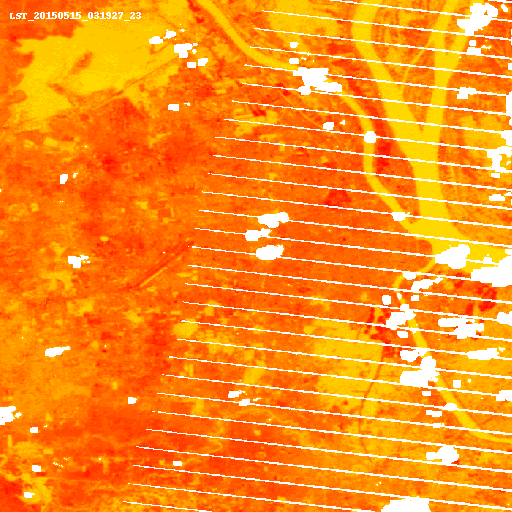

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import imageio
import os
from IPython.display import Image as IPImage, display

# Path to the directory where images are saved
image_directory = 'LST_AOI/'

# Collect filenames of all downloaded images
image_filenames = [filename for filename in os.listdir(image_directory) if filename.endswith('.png')]

# Sort image filenames based on datetime
image_filenames.sort()

# List to store image frames for creating animation
image_frames = []

# Load images and append them to the image_frames list
for image_filename in image_filenames:
    image_path = os.path.join(image_directory, image_filename)
    image = Image.open(image_path)

    # Extract the base filename without extension
    base_filename = os.path.splitext(image_filename)[0]

    # Add the base filename as a text caption
    draw = ImageDraw.Draw(image)
    caption = base_filename
    draw.text((10, 10), caption, fill=(255, 255, 255))

    image_frames.append(image)

# Create the time-series animation
animation_filename = 'LST_time_series_animation.gif'
imageio.mimsave(animation_filename, image_frames, duration=0.5)

# Display the animation in the notebook
display(IPImage(animation_filename))
